**Imports**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

**Constants**

In [3]:
################################################################################
# DEFINE CONSTANTS
################################################################################
# Internal Units
# Length: m
# Mass: kg
# Time: s
# Temperature: K
# Amount: mol

Rg = 8.314 #J/mol/K

min_to_s = 60 #seconds
L_to_m3 = 0.001 #m3
m3_to_L = 1000 #L

**Physical Properties**

PA  = Phthalic Anhydride \
B   = Butanol \
MBP = Monobutyl Phthalate \
DBP = Dibutyl Phthalate \
W   = Water \
DBE = Dibutyl Ether \
SA  = Sulfuric Acid 

In [13]:
# Molecular Weights from NIST
# Units g/mol or kg/kmol
PA_MW = 148.1156
B_MW = 74.1216
MBP_MW = 222.2372
DBP_MW = 278.3435
W_MW = 18.0153
DBE_MW = 130.2279
SA_MW = 98.078

**Mass Balance**

We want to produce 63 ktonnes per year of DBP

In [16]:
molar_flow_per_hour = 63 * 1000 * 1000 / 351 / 278.3435 / 24 # ktonnes/yr to kmol/hr
print(molar_flow_per_hour, "kmol/hr")

26.86835682756191 kmol/hr


**Reaction Network**

In [4]:
species = ['PA', 'B', 'MBP', 'DBP', 'DBE', 'W']
nRxns = 3
nSpecies = len(species)

nu = np.zeros((nSpecies, nRxns))

In [17]:
# R1: PA + B -> MBP
nu[0,0] = -1 #PA
nu[1,0] = -1 #B
nu[2,0] = +1  #MBP

# R2: MBP + B <-> DBP + W
nu[1, 1] = -1 #B
nu[2, 1] = -1 #MBP
nu[3, 1] = +1 #DBP
nu[5, 1] = +1 #W

# R3: 2B -> DBE + W
nu[1, 2] = -2 #B
nu[4, 2] = +1 #DBE
nu[5, 2] = +1 #W

print(nu)

[[-1.  0.  0.]
 [-1. -1. -2.]
 [ 1. -1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  1.]]


**Kinetic Parameters**

In [6]:
# R1: PA + B -> MBP
# No data given, treating as fast, irreversible

# R2: MBP + B <-> DBP + W
### Forward
E2f = 89.97e3  # J/mol
A2f = 3.663e10 # 1/(M^3 * min)

### Backward
E2b = 92.03e3  # J/mol
A2b = 8.480e10 # 1/(M^3 * min)

# R3: 2B -> DBE + W
E3 = 98.5e3    # J/mol
A3 = 2.45e8    # 1/(M^2 * min)

**Rate Constants**

In [7]:
def k_values(T):
    """
    Return k2f, k2b, k3 at temperature T [K].
    Units: 1/(M^order * s)
    """
    k2f = (A2f * np.exp(-E2f / (Rg * T))) / min_to_s
    k2b = (A2b * np.exp(-E2b / (Rg * T))) / min_to_s
    k3  = (A3  * np.exp(-E3  / (Rg * T)))  / min_to_s
    return k2f, k2b, k3

In [18]:
k_values(130 + 273.15)

(np.float64(0.0013433455030103338),
 np.float64(0.0016820175087866414),
 np.float64(7.051422363864068e-07))

In [8]:
def rxn_rates(C, T, C_SA):
    """
    Reaction rates r = [r1, r2, r3] in M/s.

    C    = [PA, B, MBP, DBP, DBE, W]  (mol/L)
    T    = temperature [K]
    C_SA = sulfuric acid concentration [M]
    """
    C_PA, C_B, C_MBP, C_DBP, C_DBE, C_W = C
    k2f, k2b, k3 = k_values(T)

    # Rxn 1: PA + B -> MBP, treated as instantaneous in feed
    r1 = 0.0

    # Rxn 2: MBP + B <-> DBP + W
    r2f = k2f * C_SA * C_B   * (C_MBP**2)
    r2b = k2b * C_SA * C_MBP * C_DBP * C_W
    r2  = r2f - r2b

    # Rxn 3: B -> DBE   (empirical law uses B^2 and SA)
    r3  = k3  * C_SA * (C_B**2)

    return np.array([r1, r2, r3])

In [9]:
def effective_feed(C_PA0, C_B0, C_MBP0, C_DBP0, C_DBE0, C_W0):
    """
    Apply Rxn 1 as instantaneous & complete (PA + B -> MBP)
    before the kinetic reactions 2 and 3.

    Inputs: true feed concentrations [M].
    Returns: effective inlet concentrations [M] to the CSTR.
    """
    if C_B0 < C_PA0:
        raise ValueError("Need B in excess for Rxn 1 completion.")

    C_PA_in  = 0.0
    C_MBP_in = C_MBP0 + C_PA0
    C_B_in   = C_B0   - C_PA0

    return np.array([C_PA_in, C_B_in, C_MBP_in, C_DBP0, C_DBE0, C_W0])

In [10]:
############################################################
# CSTR model
############################################################

def cstr_residual(C, C_in, tau, T, C_SA):
    """
    Steady-state CSTR balances.

    C     : outlet concentrations [M]
    C_in  : inlet concentrations [M]
    tau   : residence time [s]
    T     : temperature [K]
    C_SA  : acid concentration [M]
    """
    r_vec = rxn_rates(C, T, C_SA)     # (3,)
    R_net = nu @ r_vec                # (6,)
    return C_in - C + tau * R_net

def solve_cstr(C_in, tau, T, C_SA):
    C_guess = C_in.copy()
    C_out   = opt.fsolve(cstr_residual, C_guess,
                         args=(C_in, tau, T, C_SA))
    return C_out


In [19]:
def wtpercent_to_C_SA(wt_SA, rho_liq=1100.0):
    """
    Convert sulfuric acid loading from wt% (of 98 wt% H2SO4)
    to mol/L of H2SO4 in the liquid phase.

    wt_SA : mass% of commercial 98 wt% H2SO4 in liquid (1–4)
    rho_liq : liquid density [g/L], default ~1.1 g/mL = 1100 g/L

    Returns C_SA [mol/L].
    """
    # mass of commercial acid per L [g/L]
    mass_acid_solution = (wt_SA / 100.0) * rho_liq
    # mass of pure H2SO4 per L
    mass_H2SO4 = 0.98 * mass_acid_solution
    # mol/L
    C_SA = mass_H2SO4 / SA_MW
    return C_SA

In [20]:
def C_in_func(T_K):
    """
    Build inlet concentration vector [PA, B, MBP, DBP, DBE, W] in mol/L.
    T_K included in case you later want T-dependent density.
    """
    # true feed before fast Rxn 1
    C_PA0  = 2.0   # <-- replace with your design values
    C_B0   = 8.0
    C_MBP0 = 0.0
    C_DBP0 = 0.0
    C_DBE0 = 0.0
    C_W0   = 0.0

    return effective_feed(C_PA0, C_B0, C_MBP0, C_DBP0, C_DBE0, C_W0)

In [21]:
idx = {name: i for i, name in enumerate(species)}

def performance_at_tau(tau_s, T_K, C_SA):
    """
    Compute outlet and key metrics at given tau, T, C_SA.
    """
    C_in  = C_in_func(T_K)                  # mol/L
    C_out = solve_cstr(C_in, tau_s, T_K, C_SA)

    C_PA0 = C_in[idx['PA']]
    C_B0  = C_in[idx['B']]

    C_PA  = C_out[idx['PA']]
    C_B   = C_out[idx['B']]
    C_MBP = C_out[idx['MBP']]
    C_DBP = C_out[idx['DBP']]
    C_DBE = C_out[idx['DBE']]

    # conversions
    X_PA = 1.0 - C_PA / C_PA0
    X_B  = 1.0 - C_B  / C_B0

    # organic product distribution
    organics = C_MBP + C_DBP + C_DBE
    y_DBP = C_DBP / organics if organics > 0 else 0.0
    y_DBE = C_DBE / organics if organics > 0 else 0.0

    return {
        "C_in": C_in,
        "C_out": C_out,
        "X_PA": X_PA,
        "X_B": X_B,
        "y_DBP": y_DBP,
        "y_DBE": y_DBE
    }

In [22]:
tau_min_design = 30.0          # min, choose >= 5
tau_s = tau_min_design * min_to_s

T_C_vals   = np.linspace(80.0, 150.0, 30)   # °C
wt_SA_vals = np.linspace(1.0, 4.0, 16)      # wt%

# allocate result arrays: [len(wt_SA) x len(T)]
X_PA_grid   = np.zeros((len(wt_SA_vals), len(T_C_vals)))
X_B_grid    = np.zeros_like(X_PA_grid)
y_DBP_grid  = np.zeros_like(X_PA_grid)
y_DBE_grid  = np.zeros_like(X_PA_grid)

for i, wt_SA in enumerate(wt_SA_vals):
    C_SA = wtpercent_to_C_SA(wt_SA)
    for j, T_C in enumerate(T_C_vals):
        T_K = T_C + 273.15
        perf = performance_at_tau(tau_s, T_K, C_SA)

        X_PA_grid[i, j]  = perf["X_PA"]
        X_B_grid[i, j]   = perf["X_B"]
        y_DBP_grid[i, j] = perf["y_DBP"]
        y_DBE_grid[i, j] = perf["y_DBE"]

/var/folders/68/jrllnq_n1kg4x387gq0q1c4r0000gn/T/ipykernel_11247/3101243690.py:20: RuntimeWarning: invalid value encountered in scalar divide
  X_PA = 1.0 - C_PA / C_PA0


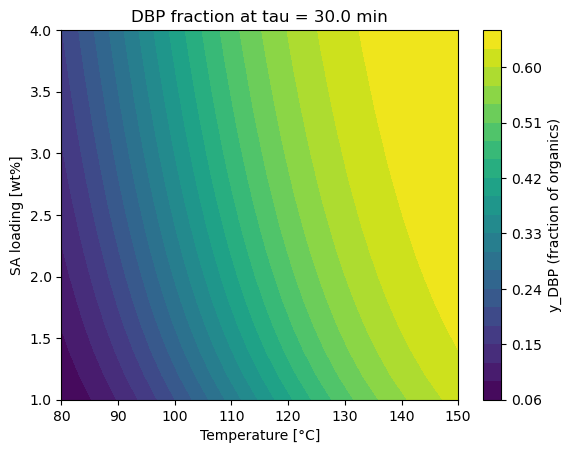

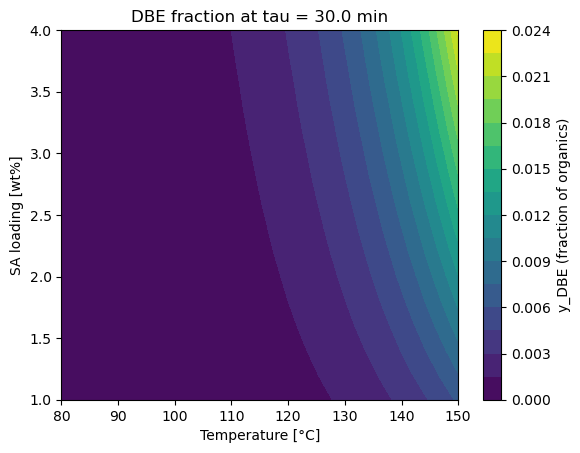

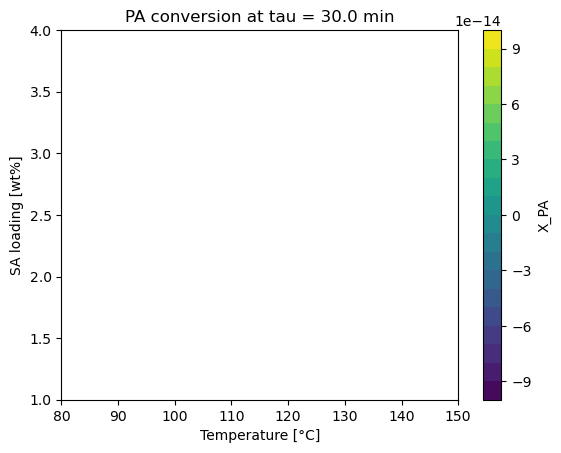

In [23]:
T_mesh, SA_mesh = np.meshgrid(T_C_vals, wt_SA_vals)

plt.figure()
cp = plt.contourf(T_mesh, SA_mesh, y_DBP_grid, levels=20)
plt.colorbar(cp, label='y_DBP (fraction of organics)')
plt.xlabel('Temperature [°C]')
plt.ylabel('SA loading [wt%]')
plt.title(f'DBP fraction at tau = {tau_min_design:.1f} min')

plt.figure()
cp = plt.contourf(T_mesh, SA_mesh, y_DBE_grid, levels=20)
plt.colorbar(cp, label='y_DBE (fraction of organics)')
plt.xlabel('Temperature [°C]')
plt.ylabel('SA loading [wt%]')
plt.title(f'DBE fraction at tau = {tau_min_design:.1f} min')

plt.figure()
cp = plt.contourf(T_mesh, SA_mesh, X_PA_grid, levels=20)
plt.colorbar(cp, label='X_PA')
plt.xlabel('Temperature [°C]')
plt.ylabel('SA loading [wt%]')
plt.title(f'PA conversion at tau = {tau_min_design:.1f} min')

plt.show()

In [25]:
# Operating Point
T_C = 130
T_K = T_C + 273.15

tau_min = 5.0
tau_s = tau_min * min_to_s

def wtpercent_to_C_SA(wt_SA, rho_liq=1100.0):
    """
    Convert sulfuric acid loading from wt% (of 98 wt% H2SO4)
    to mol/L of H2SO4 in the liquid phase.

    wt_SA : mass% of commercial 98 wt% H2SO4 in liquid (1–4)
    rho_liq : liquid density [g/L], default ~1.1 g/mL = 1100 g/L

    Returns C_SA [mol/L].
    """
    # mass of commercial acid per L [g/L]
    mass_acid_solution = (wt_SA / 100.0) * rho_liq
    # mass of pure H2SO4 per L
    mass_H2SO4 = 0.98 * mass_acid_solution
    # mol/L
    C_SA = mass_H2SO4 / SA_MW
    return C_SA

C_SA = wtpercent_to_C_SA(2.0)

print(C_SA, "mol/L")
print(T_K, "K")
print(tau_s, "s")

0.21982503721527763 mol/L
403.15 K
300.0 s


In [26]:
def rxn_rates(C, T, C_SA):
    C_PA, C_B, C_MBP, C_DBP, C_DBE, C_W = C
    k2f, k2b, k3 = k_values(T)

    # Rxn 1: PA + B -> MBP (instantaneous, handled in feed)
    r1 = 0.0

    # Rxn 2: MBP + B <-> DBP + W
    r2f = k2f * C_SA * C_B   * (C_MBP**2)
    r2b = k2b * C_SA * C_MBP * C_DBP * C_W
    r2  = r2f - r2b

    # Rxn 3: B -> DBE (empirical: SA * B^2)
    r3  = k3  * C_SA * (C_B**2)

    return np.array([r1, r2, r3])

In [27]:
# ---- TRUE FEED BEFORE Rxn 1 (overall system feed) ----
PA_to_B_ratio = 2.52

C_PA0_feed  = 2.0                  # M  (choose / compute from flows)
C_B0_feed   = PA_to_B_ratio * C_PA0_feed   # = 5.04 M

C_MBP0_feed = 0.0
C_DBP0_feed = 0.0
C_DBE0_feed = 0.0
C_W0_feed   = 0.0


In [28]:
def effective_feed(C_PA0, C_B0, C_MBP0, C_DBP0, C_DBE0, C_W0):
    """
    Apply PA + B -> MBP as instantaneous & complete.
    """
    if C_B0 >= C_PA0:      # B in excess (your case: 2.52 > 1)
        C_PA_in  = 0.0
        C_MBP_in = C_MBP0 + C_PA0
        C_B_in   = C_B0 - C_PA0     # = (2.52 - 1)*C_PA0 = 1.52*C_PA0
    else:                  # safety fallback if B ever limiting
        C_PA_in  = C_PA0 - C_B0
        C_MBP_in = C_MBP0 + C_B0
        C_B_in   = 0.0

    return np.array([
        C_PA_in,
        C_B_in,
        C_MBP_in,
        C_DBP0,
        C_DBE0,
        C_W0
    ])


In [29]:
def C_in_func(T_K):
    return effective_feed(
        C_PA0_feed, C_B0_feed,
        C_MBP0_feed, C_DBP0_feed, C_DBE0_feed, C_W0_feed
    )


In [30]:
tau_min = 5.0
tau_s   = tau_min * min_to_s

T_C = 130.0
T_K = T_C + 273.15

C_SA = wtpercent_to_C_SA(2.0)   # ~0.22 M

idx = {name: i for i, name in enumerate(species)}

C_in  = C_in_func(T_K)
C_out = solve_cstr(C_in, tau_s, T_K, C_SA)

for name, val in zip(species, C_out):
    print(f"{name:4s}: {val:8.4f} M")

C_PA  = C_out[idx['PA']]
C_B   = C_out[idx['B']]
C_MBP = C_out[idx['MBP']]
C_DBP = C_out[idx['DBP']]
C_DBE = C_out[idx['DBE']]

# conversions on FRESH feed basis (before Rxn 1)
X_PA = 1.0 - C_PA / C_PA0_feed
X_B  = 1.0 - C_B  / C_B0_feed

organics = C_MBP + C_DBP + C_DBE
y_DBP = C_DBP / organics if organics > 0 else 0.0
y_DBE = C_DBE / organics if organics > 0 else 0.0

print(f"\nX_PA  = {X_PA:.3f}")
print(f"X_B   = {X_B:.3f}")
print(f"y_DBP = {y_DBP:.3f}")
print(f"y_DBE = {y_DBE:.3f}")


PA  :   0.0000 M
B   :   2.5569 M
MBP :   1.5175 M
DBP :   0.4825 M
DBE :   0.0003 M
W   :   0.4828 M

X_PA  = 1.000
X_B   = 0.493
y_DBP = 0.241
y_DBE = 0.000


# Starting from the Top, modelling only Rxn 2 and 3

In [31]:
species  = ['MBP', 'B', 'DBP', 'DBE', 'W']
nSpecies = len(species)
nRxns    = 2   # R2, R3

# nu[i, j] = stoich coefficient for species i in reaction j
nu = np.zeros((nSpecies, nRxns))

# R2: MBP + B ⇌ DBP + W   (use forward stoich)
# MBP  B   DBP DBE W
nu[:, 0] = np.array([-1, -1, +1,  0, +1])

# R3: 2 B → DBE + W
nu[:, 1] = np.array([ 0, -2,  0, +1, +1])


In [32]:
# ---- kinetic parameters (from papers) ----
# R2 forward
E2f = 89.97e3       # J/mol
A2f = 3.663e10      # 1/(M^3 * min)

# R2 backward
E2b = 92.03e3       # J/mol
A2b = 8.480e10      # 1/(M^3 * min)

# R3
E3  = 98.5e3        # J/mol
A3  = 2.45e8        # 1/(M^2 * min)

def k_values(T_K):
    """Return k2f, k2b, k3 in 1/(M^n * s) at temperature T_K."""
    k2f = A2f * np.exp(-E2f / (Rg*T_K)) / min_to_s
    k2b = A2b * np.exp(-E2b / (Rg*T_K)) / min_to_s
    k3  = A3  * np.exp(-E3  / (Rg*T_K)) / min_to_s
    return k2f, k2b, k3


In [33]:
def wtpercent_to_C_SA(wt_SA, rho_liq=1100.0):
    """
    Convert sulfuric acid loading from wt% (of 98 wt% H2SO4)
    to mol/L of H2SO4 in the liquid phase.

    wt_SA : mass% of commercial 98 wt% H2SO4 in liquid (1–4)
    rho_liq : liquid density [g/L], default ~1.1 g/mL = 1100 g/L

    Returns C_SA [mol/L].
    """
    # mass of commercial acid per L [g/L]
    mass_acid_solution = (wt_SA / 100.0) * rho_liq
    # mass of pure H2SO4 per L
    mass_H2SO4 = 0.98 * mass_acid_solution
    # mol/L
    C_SA = mass_H2SO4 / SA_MW
    return C_SA

In [34]:
T_C  = 130.0
T_K  = T_C + 273.15
tau_min = 5.0
tau_s   = tau_min * min_to_s
C_SA    = wtpercent_to_C_SA(2.0)


In [35]:
def rxn_rates(C, T, C_SA):
    """
    Reaction rates r_vec = [r2, r3] in M/s.
    C = [C_MBP, C_B, C_DBP, C_DBE, C_W]
    """
    C_MBP, C_B, C_DBP, C_DBE, C_W = C
    k2f, k2b, k3 = k_values(T)

    # R2: MBP + B ⇌ DBP + W
    r2f = k2f * C_SA * C_B * C_MBP**2
    r2b = k2b * C_SA * C_MBP * C_DBP * C_W
    r2  = r2f - r2b

    # R3: 2B → DBE + W
    r3  = k3 * C_SA * C_B**2

    return np.array([r2, r3])


In [36]:
def cstr_residual(C, C_in, tau, T, C_SA):
    """
    Steady-state CSTR balances:
    C_in - C + tau * R_net = 0
    """
    r_vec = rxn_rates(C, T, C_SA)   # (2,)
    R_net = nu @ r_vec              # (5,)
    return C_in - C + tau * R_net

def solve_cstr(C_in, tau, T, C_SA):
    C_guess = C_in.copy()
    C_out = opt.fsolve(cstr_residual, C_guess,
                       args=(C_in, tau, T, C_SA))
    return C_out


In [37]:
PA_to_B_ratio = 2.52

C_PA0_overall = 2.0       # M, choose / compute from flows
C_B0_overall  = PA_to_B_ratio * C_PA0_overall

# After R1 goes to completion (PA limiting):
C_MBP0 = C_PA0_overall
C_B0   = C_B0_overall - C_PA0_overall
C_DBP0 = 0.0
C_DBE0 = 0.0
C_W0   = 0.0

C_in = np.array([C_MBP0, C_B0, C_DBP0, C_DBE0, C_W0])


In [38]:
C_out = solve_cstr(C_in, tau_s, T_K, C_SA)
C_MBP, C_B, C_DBP, C_DBE, C_W = C_out

print("Outlet concentrations [M]:")
for name, val in zip(species, C_out):
    print(f"{name:4s} = {val:8.4f}")

# Example performance metrics
X_MBP = 1.0 - C_MBP / C_MBP0
X_B   = 1.0 - C_B   / C_B0
y_DBP = C_DBP / (C_MBP + C_DBP + C_DBE + 1e-12)   # organic selectivity

print(f"\nX_MBP = {X_MBP:.3f}")
print(f"X_B   = {X_B:.3f}")
print(f"y_DBP = {y_DBP:.3f}")


Outlet concentrations [M]:
MBP  =   1.5175
B    =   2.5569
DBP  =   0.4825
DBE  =   0.0003
W    =   0.4828

X_MBP = 0.241
X_B   = 0.159
y_DBP = 0.241


In [45]:
idx = {name: i for i, name in enumerate(species)}

def metrics_at_tau(tau_min, T_K, C_SA, C_in, C_MBP0, C_B0):
    """
    Evaluate reactor performance for a given residence time tau_min [min].

    Returns:
      X_MBP, X_B, y_DBP, impurity
    """
    tau_s = tau_min * min_to_s
    C_out = solve_cstr(C_in, tau_s, T_K, C_SA)

    C_MBP = C_out[idx['MBP']]
    C_B   = C_out[idx['B']]
    C_DBP = C_out[idx['DBP']]
    C_DBE = C_out[idx['DBE']]

    # conversions
    X_MBP = 1.0 - C_MBP / C_MBP0
    X_B   = 1.0 - C_B   / C_B0

    # organic pool
    organics = C_MBP + C_DBP + C_DBE
    y_DBP = C_DBP / organics if organics > 0 else 0.0

    impurity = 1.0 - y_DBP    # fraction of organics that are NOT DBP

    return X_MBP, X_B, y_DBP, impurity


In [46]:
# Specs
X_MBP_target = 0.75      # example: want at least 50% MBP conversion
                           # (change this if you want more/less)


In [59]:
# Operating point
T_C  = 130.0
T_K  = T_C + 273.15
C_SA = wtpercent_to_C_SA(2.0)  # 2 wt% SA

# Inlet and reference concentrations (post-R1)
C_in   = np.array([C_MBP0, C_B0, 0.0, 0.0, 0.0])
C_MBP0 = C_in[idx['MBP']]
C_B0   = C_in[idx['B']]

# τ-sweep: start at 5 min (R1 completion assumption), go up to e.g. 300 min
tau_min_values = np.linspace(5.0, 300.0, 80)  # [min]

results = []
for tau_min in tau_min_values:
    X_MBP, X_B, y_DBP, impurity = metrics_at_tau(
        tau_min, T_K, C_SA, C_in, C_MBP0, C_B0
    )
    results.append((tau_min, X_MBP, X_B, y_DBP, impurity))

# Find the smallest tau that achieves the target MBP conversion
feasible = [r for r in results if r[1] >= X_MBP_target]

if not feasible:
    # Report max conversion achieved so you can decide to adjust T/SA or target
    X_MBP_max = max(r[1] for r in results)
    print(f"No tau in the scanned range reaches X_MBP_target = {X_MBP_target:.3f}.")
    print(f"Max X_MBP in [5, 300] min is {X_MBP_max:.3f}. Consider increasing tau_max or changing T/SA.")
else:
    tau_star, X_MBP_star, X_B_star, y_DBP_star, impurity_star = feasible[0]
    print(f"tau*        = {tau_star:.1f} min")
    print(f"X_MBP*      = {X_MBP_star:.3f}")
    print(f"X_B*        = {X_B_star:.3f}")
    print(f"DBP fraction y_DBP = {y_DBP_star:.3f} (impurity = {impurity_star:.3f})")


tau*        = 113.3 min
X_MBP*      = 0.521
X_B*        = 0.345
DBP fraction y_DBP = 0.520 (impurity = 0.480)


In [57]:
# 1) Find max conversion from the sweep (effective equilibrium at this T, SA, feed)
X_MBP_max = max(r[1] for r in results)
print(f"Max X_MBP in [5, 300] min is {X_MBP_max:.3f}")

# 2) Define a design target as 90–95% of that max
X_MBP_target = 0.95 * X_MBP_max   # or 0.95 if you want closer to equilibrium
print(f"Design target X_MBP = {X_MBP_target:.3f}")

# 3) Pick the smallest tau that achieves that target
feasible = [r for r in results if r[1] >= X_MBP_target]

if not feasible:
    print("Even 90–95% of X_MBP_max not reached in this τ range; extend tau_max if needed.")
else:
    tau_star, X_MBP_star, X_B_star, y_DBP_star, impurity_star = feasible[0]
    print(f"\ntau*        = {tau_star:.1f} min")
    print(f"X_MBP*      = {X_MBP_star:.3f}")
    print(f"X_B*        = {X_B_star:.3f}")
    print(f"y_DBP*      = {y_DBP_star:.3f}  (impurity = {impurity_star:.3f})")


Max X_MBP in [5, 300] min is 0.547
Design target X_MBP = 0.520

tau*        = 113.3 min
X_MBP*      = 0.521
X_B*        = 0.345
y_DBP*      = 0.520  (impurity = 0.480)


In [53]:
tau_s = tau_star * 60.0


In [ ]:
Vdot_liq = 

V_reactor = tau_s * Vdot_liq   # m^3
print(f"Design CSTR volume V = {V_reactor:.2f} m^3")


NameError: name 'Vdot_liq' is not defined

In [62]:
# Known from problem + model
n_dbp_kmol_hr = 26.868       # kmol/hr DBP production
X_MBP_star    = 0.521        # from kinetics at tau_star
tau_star_min  = 113.3        # min (from sweep)
rho_MBP       = 4.781649239  # kmol/m3 pure MBP at 130 C
PA_to_B_ratio = 2.52

# 1) MBP feed rate
n_MBP_in_kmol_hr = n_dbp_kmol_hr / X_MBP_star

# 2) Approx MBP concentration in reactor feed (kmol/m3)
z_MBP   = 1.0 / (1.0 + PA_to_B_ratio)        # ~0.284
C_MBP_0 = z_MBP * rho_MBP                    # ~1.36 kmol/m3

# 3) Volumetric flowrate
Vdot_liq_m3_hr = n_MBP_in_kmol_hr / C_MBP_0  # ~38 m3/hr

# 4) Reactor volume
tau_star_hr = tau_star_min / 60.0
V_reactor_m3 = tau_star_hr * Vdot_liq_m3_hr

print(f"n_MBP,in   = {n_MBP_in_kmol_hr:.2f} kmol/hr")
print(f"C_MBP,0    = {C_MBP_0:.3f} kmol/m^3")
print(f"Vdot_liq   = {Vdot_liq_m3_hr:.2f} m^3/hr")
print(f"Design CSTR volume V = {V_reactor_m3:.3f} m^3")


n_MBP,in   = 51.57 kmol/hr
C_MBP,0    = 1.358 kmol/m^3
Vdot_liq   = 37.96 m^3/hr
Design CSTR volume V = 71.687 m^3
